In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from acq import UCB, EI, PI, KG, find_next_batch, optimize_acqf
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('../')
sys.path.append("../GaussianProcess")
import GaussianProcess.kernel as kernel
from cigp import CIGP_withMean



## Define the objective function
This objective function represents a simple sum of sine functions. The goal is to demonstrate a basic mathematical function that exhibits periodic behavior with different frequencies. The input 'x' is the variable at which the sine functions are evaluated, and the result is the sum of sin(x) and sin(2x).

In [18]:
def objective_function(x):
    # Simple sum of sine functions for demonstration
    return torch.sin(x)+torch.sin(2*x)

## Initialize prior knowledge with 5 random points

In [19]:
input_dim = 1
num_initial_points = 5
train_x = torch.rand(num_initial_points, input_dim) * 10  # Random points in [0, 10] for each dimension
train_y = objective_function(train_x).reshape(-1,1)

# Initialize the surrogate model
This code initializes a surrogate model for Bayesian optimization. The surrogate model (CIGP_withMean) is equipped with a chosen kernel (ARDKernel) to capture the underlying patterns in the data.  The Adam optimizer is then set up to optimize the model's parameters during the training process. 

In [20]:
kernel1 = kernel.ARDKernel(1)
# kernel1 = kernel.MaternKernel(1)
# kernel1 = kernel.LinearKernel(1,-1.0,1.)
# kernel1 = kernel.SumKernel(kernel.LinearKernel(1), kernel.MaternKernel(1))
model = CIGP_withMean(1, 1, kernel=kernel1, noise_variance=2.)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)

# Define the mean and variance functions for acq function
The defined mean and variance functions extract the predictive mean and variance from the trained surrogate model (model) when provided with input points (X). These functions are crucial components in the computation of acquisition functions, such as the Upper Confidence Bound (UCB), and are used to guide the selection of the next point for evaluation in the Bayesian optimization process.

In [21]:
def mean_function(X):
    model.eval()
    with torch.no_grad():
        mean, _ = model.forward(train_x, train_y, X)
        return mean

def variance_function(X):
    model.eval()
    with torch.no_grad():
        _, var = model.forward(train_x, train_y, X)
        return var

# Initialize acq function
The code snippet initializes different acquisition functions for Bayesian optimization.

In [22]:
ucb = UCB(mean_function, variance_function, kappa=5)
pi = PI(mean_function, variance_function)
ei = EI(mean_function, variance_function)
kg = KG(mean_function, variance_function, num_fantasies=10)
best_y = []
# use it to remember the key iteration
key_iterations = [2,4,5,6,8,10]
predictions = []
iteration_label = True


# Bayesian optimization loop
The key iterations allow monitoring the model's behavior and predictions at specific points during the optimization process. The overall process aims to iteratively improve the surrogate model and select points for evaluation that are expected to yield the best objective values.

In [23]:
# Bayesian optimization loop
bounds = torch.tensor([[0, 10]] * input_dim)
for iteration in range(10):  # Run for 5 iterations

    for i in range(100):
        optimizer.zero_grad()
        loss = -model.log_likelihood(train_x, train_y)
        loss.backward()
        optimizer.step()
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))


    #batch_points = find_next_batch(ucb, bounds, batch_size=1, n_samples=500, f_best=train_x[np.argmax(train_y)])
    # batch_points = ei.find_next_batch(bounds, batch_size=1, n_samples=1000, f_best=train_x[np.argmax(train_y)])
    #find_next_batch(acq)
    batch_points = optimize_acqf(acq=ucb, q=1, raw_samples=50, bounds=bounds, f_best=0, num_restarts=30, options=None, return_best_only=False)
    batch_points = torch.tensor(batch_points).float()

    # Evaluate the objective function
    new_y = objective_function(batch_points.squeeze()).reshape(-1,1)

    # Update the model
    train_x = torch.cat([train_x, batch_points])
    train_y = torch.cat([train_y, new_y])
    # Store the best objective value found so far
    best_y.append(new_y.max().item())
    # Visualization

    # 在关键迭代时保存模型预测
    if (iteration + 1) in key_iterations:
        model.eval()
        fixed_dims = torch.full((1, input_dim - 1), 5.0)  # Example: set them to the midpoint (5.0)
        test_points = torch.linspace(0, 10, 100)
        test_X = torch.cat((test_points.unsqueeze(1), fixed_dims.expand(test_points.size(0), -1)), 1)
        true_y = objective_function(test_X)

        with torch.no_grad():
            pred_mean, pred_std = model.forward(train_x, train_y, test_X)
            predictions.append((pred_mean, pred_std))


iter 0 nll:8.65826
iter 1 nll:8.58797
iter 2 nll:8.51692
iter 3 nll:8.44512
iter 4 nll:8.37256
iter 5 nll:8.29924
iter 6 nll:8.22518
iter 7 nll:8.15038
iter 8 nll:8.07486
iter 9 nll:7.99865
iter 10 nll:7.92178
iter 11 nll:7.84430
iter 12 nll:7.76626
iter 13 nll:7.68776
iter 14 nll:7.60886
iter 15 nll:7.52970
iter 16 nll:7.45040
iter 17 nll:7.37112
iter 18 nll:7.29207
iter 19 nll:7.21346
iter 20 nll:7.13556
iter 21 nll:7.05866
iter 22 nll:6.98311
iter 23 nll:6.90931
iter 24 nll:6.83768
iter 25 nll:6.76870
iter 26 nll:6.70290
iter 27 nll:6.64076
iter 28 nll:6.58276
iter 29 nll:6.52920
iter 30 nll:6.48010
iter 31 nll:6.43670
iter 32 nll:6.47999
iter 33 nll:6.51349
iter 34 nll:6.53806
iter 35 nll:6.55349
iter 36 nll:6.55962
iter 37 nll:6.55682
iter 38 nll:6.54621
iter 39 nll:6.52951
iter 40 nll:6.50877
iter 41 nll:6.48605
iter 42 nll:6.46320
iter 43 nll:6.45657
iter 44 nll:6.45710
iter 45 nll:6.45664
iter 46 nll:6.45566
iter 47 nll:6.45427
iter 48 nll:6.45245
iter 49 nll:6.45018
iter 50 nl

C:\Users\24779\AppData\Local\Temp\ipykernel_28964\3894418734.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_points = torch.tensor(batch_points).float()


iter 0 nll:7.48678
iter 1 nll:7.47320
iter 2 nll:7.46638
iter 3 nll:7.46319
iter 4 nll:7.45337
iter 5 nll:7.44353
iter 6 nll:7.43932
iter 7 nll:7.43422
iter 8 nll:7.42545
iter 9 nll:7.41874
iter 10 nll:7.41501
iter 11 nll:7.40929
iter 12 nll:7.40176
iter 13 nll:7.39634
iter 14 nll:7.39214
iter 15 nll:7.38588
iter 16 nll:7.37929
iter 17 nll:7.37464
iter 18 nll:7.36980
iter 19 nll:7.36355
iter 20 nll:7.35823
iter 21 nll:7.35401
iter 22 nll:7.34874
iter 23 nll:7.34339
iter 24 nll:7.33928
iter 25 nll:7.33480
iter 26 nll:7.32978
iter 27 nll:7.32572
iter 28 nll:7.32172
iter 29 nll:7.31714
iter 30 nll:7.31324
iter 31 nll:7.30956
iter 32 nll:7.30540
iter 33 nll:7.30178
iter 34 nll:7.29837
iter 35 nll:7.29463
iter 36 nll:7.29137
iter 37 nll:7.28824
iter 38 nll:7.28490
iter 39 nll:7.28199
iter 40 nll:7.27911
iter 41 nll:7.27616
iter 42 nll:7.27359
iter 43 nll:7.27093
iter 44 nll:7.26837
iter 45 nll:7.26605
iter 46 nll:7.26363
iter 47 nll:7.26143
iter 48 nll:7.25930
iter 49 nll:7.25717
iter 50 nl

# plot the picture
This visualization helps to understand how well the Gaussian Process model captures the true function and how uncertainty evolves as more samples are acquired during the optimization process.

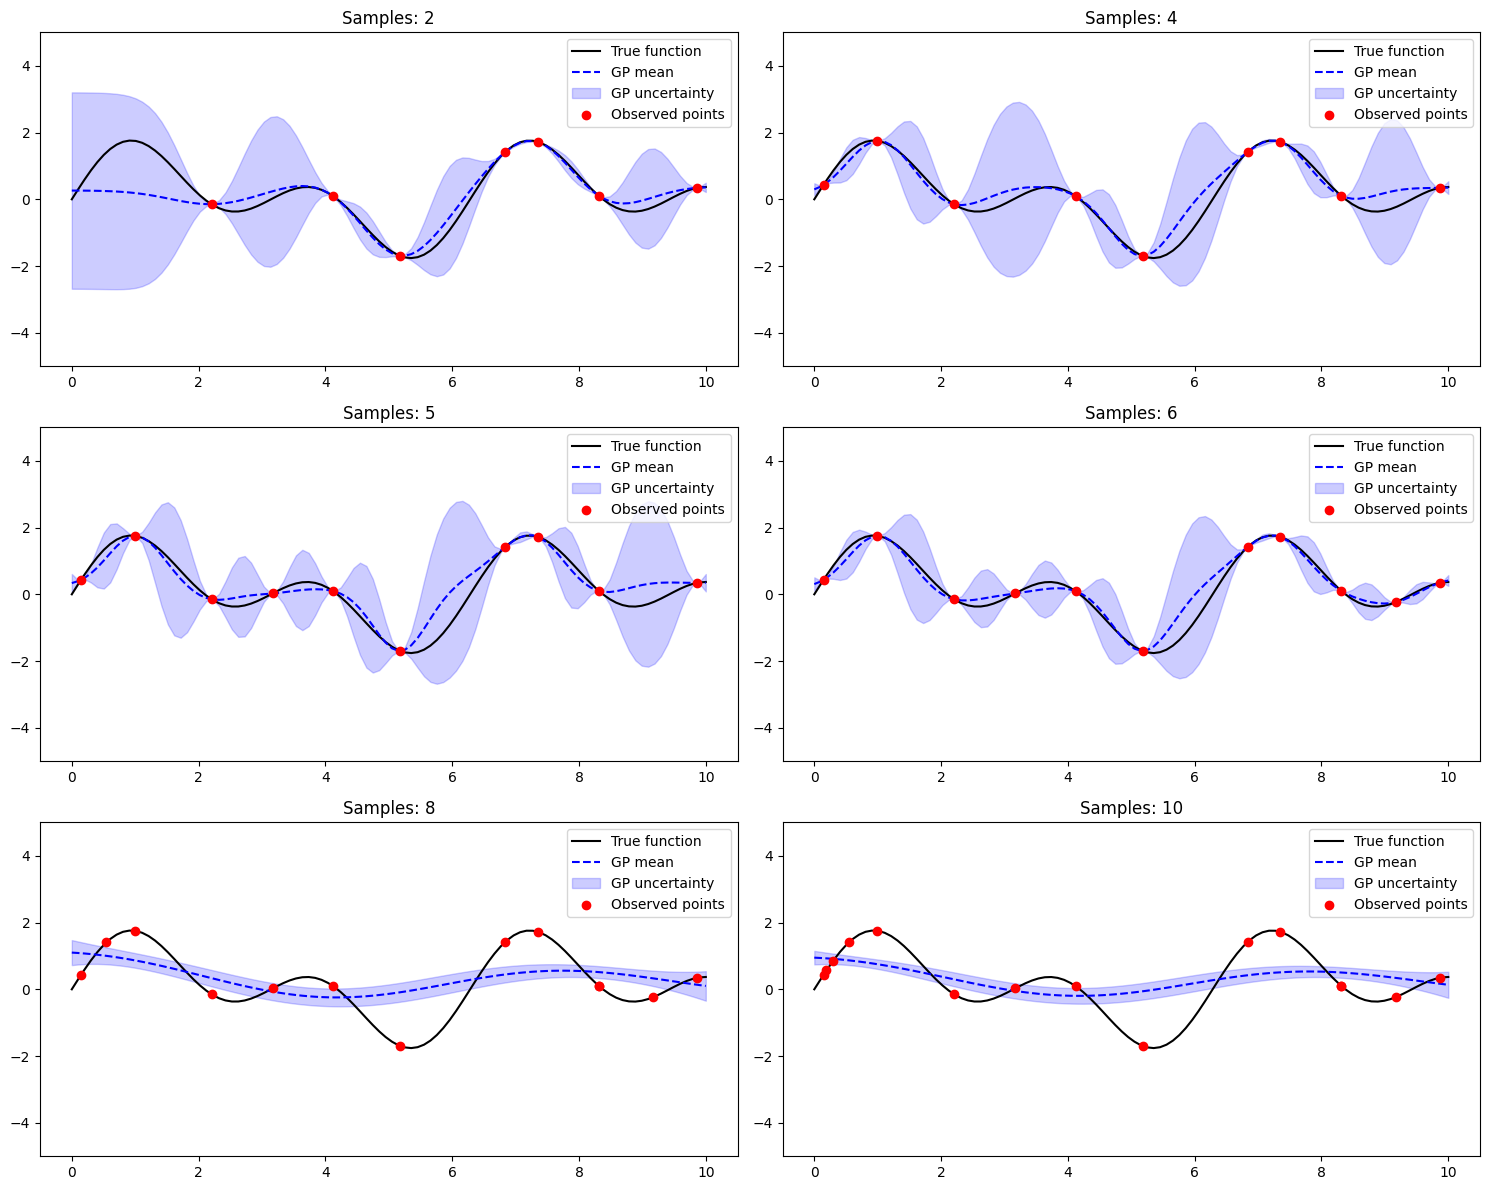

In [24]:
# 绘制子图
plt.figure(figsize=(15, 12))
for i, (pred_mean, pred_std) in enumerate(predictions):
    plt.subplot(3, 2, i+1)
    plt.ylim(-5, 5)
    plt.plot(test_points.numpy(), true_y.numpy(), 'k-', label='True function')
    plt.plot(test_points.numpy(), pred_mean.numpy(), 'b--', label='GP mean')
    plt.fill_between(test_points.numpy().reshape(-1),
                     (pred_mean - 2 * pred_std).numpy().reshape(-1),
                     (pred_mean + 2 * pred_std).numpy().reshape(-1),
                     color='blue', alpha=0.2, label='GP uncertainty')

    observed_x = train_x[:, 0].numpy()  # Only the first dimension for all observed points
    observed_y = train_y.numpy()
    plt.scatter(observed_x[:num_initial_points+key_iterations[i]], observed_y[:num_initial_points+key_iterations[i]], c='r', zorder=3, label='Observed points')
    plt.title(f'Samples: {key_iterations[i]}')
    plt.legend()

plt.tight_layout()
plt.show()
